# Visual Transformer
This notebook implements Swin Transformer technique for classifying CIFAR-10 data set. It is just for exploring the concept rather than aiming for a good results.

This is inspired by Dr Jorge Cardoso's lecture at King's College London.

## Import general library and define common structure

In [1]:
# Import library and set up environment
import os as os
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torch.optim as optim
import pandas as pd
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = torch.cuda.device_count()
print("Number of GPU workers available:", num_workers)

cuda
Number of GPU workers available: 2


In [2]:
# Create a class that aid in training and testing
class Model_Wrapper:
    def __init__(self, model, optimizer, loss_function, device):
        '''Start the model and store important object'''
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.device = device
        self.total_train_epoch = 0
        self.train_loss_list = []
        self.calculated_metrics = None

    def push_to_device(self):
        self.model = self.model.to(self.device)
        self.loss_function = self.loss_function.to(self.device)

    def train(self, num_epochs, train_loader):
        '''Train model'''
        # Start training
        expected_total_epoch = self.total_train_epoch + num_epochs
        for epoch in range(num_epochs):
            self.model.train()
            for i, (input, output) in enumerate(train_loader, 0):
                # Push data to GPU, clear gradient, calculate loss, backpropagation
                input = input.to(self.device)
                output = output.to(self.device)
                # Zero gradient
                self.optimizer.zero_grad()
                # Forward
                result, _ = self.model(input)
                # Calculate the loss
                loss = self.loss_function(result, output)
                # Calculate the gradient
                loss.backward()
                # Update the weight
                self.optimizer.step()
                # Store the loss value
                self.train_loss_list.append(loss.item())
                # print the loss
                if i % 50 == 0:
                    print(f"Epoch: {self.total_train_epoch+1}/{expected_total_epoch}; Data {i*len(output)}/{len(train_loader.dataset)}; Loss: {loss.item()}")
            self.total_train_epoch += 1

    def plot_train_loss(self, plot_title = "Loss value during training"):
        """Plot the loss value during training"""
        # Add plot
        _, ax = plt.subplots()
        ax.plot(range(len(self.train_loss_list)), self.train_loss_list)
        # Add a title and labels
        ax.set_title(plot_title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Loss value')

    def test(self, test_loader):
        """Test on test data set"""
        total_loss=[]
        # Test the model
        self.model.eval()
        for i, (input, output) in enumerate(test_loader, 0):
            # Push data to GPU, predict, and calculate the loss
            input = input.to(device)
            output = output.to(device)
            # Predict
            result, _ = self.model(input)
            # Calculate the loss
            loss = self.loss_function(output, result)
            # Append the loss
            total_loss.append(loss.item())
            # Calculate performance
            self.calculate_metrics(result, output)
        # print the loss and metrics
        print(f"Loss: {round(np.array(total_loss).mean(),4)}")
        for metric_name, metric_value in self.calculated_metrics.items():
            print(metric_name, ": ", round(np.array(metric_value).mean(),4), sep="")

    def calculate_metrics(self, labels, output):
        """Edit here to calculate the metrics"""
        """Should be individualized"""
        # Make prediction
        if (self.calculated_metrics == None):
            self.calculated_metrics = {}

## Load the dataset

100%|██████████| 170498071/170498071 [00:01<00:00, 86350626.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


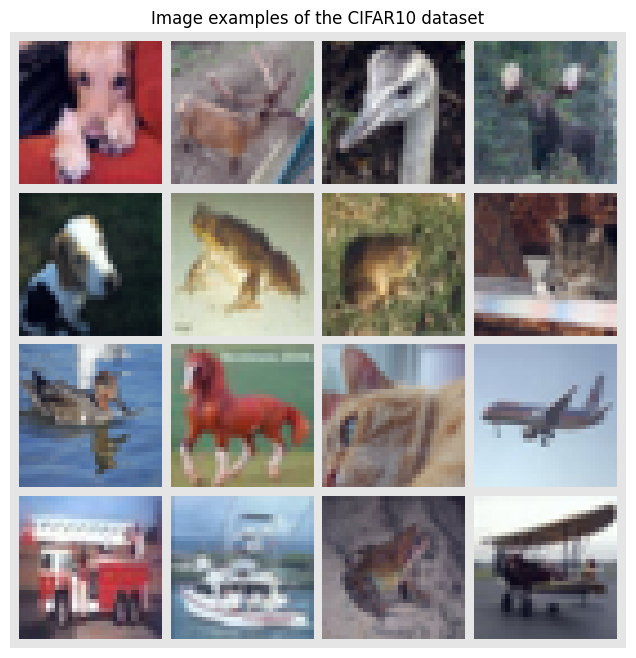

In [3]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=num_workers)

# Visualize some examples
NUM_IMAGES = 16
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

labels_list = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"]

## Function to calculate dot product

In [4]:
def scaled_dot_product(q, k, v):
    """
    Calculate the scale dot product
    q k v have dimesion of (..., sequences, features)
    """
    # Get sizes of embedding features
    d_k = q.size(-1)
    # Calculate dot product between queries and keys and normalize down
    # with the number of embedding features
    attention_value = q@k.transpose(-2,-1)/d_k
    # Calculate attention score
    attention_score = F.softmax(attention_value, dim = -1)
    # Calculate new value
    new_values = attention_score@v
    
    return new_values, attention_score

# Test
seq_len = 3
emb_dim = 10
q = torch.rand(100, seq_len, emb_dim)
k = torch.rand(100, seq_len, emb_dim)
v = torch.rand(100, seq_len, emb_dim)
values, attention = scaled_dot_product(q, k, v)
print(values.size())
print(attention.size())

torch.Size([100, 3, 10])
torch.Size([100, 3, 3])


## Module for MultiheadAttention

In [5]:
class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        """
        input_dim: size of features of input
        embed_dim: size of features of embedded dimension of 1 head
        num_heads: number of heads
        """
        super().__init__()

        self.attention_score = None
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.total_embed_dim = embed_dim*num_heads
        # Project the input to q k v. And project the output v
        self.qkv_proj = nn.Linear(embed_dim, 3*self.total_embed_dim)
        self.out_proj = nn.Linear(self.total_embed_dim, self.embed_dim)

        # Reset the parameters of the layers
        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.out_proj.weight)
        self.out_proj.bias.data.fill_(0)

    def forward(self, x):

        batch_size, seq_length, _ = x.size()

        qkv = self.qkv_proj(x)
        # Separate Q, K, V from linear output
        qkv = qkv.view(batch_size, seq_length, self.num_heads, 3*self.embed_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)
        
        # Apply the attention layer
        output, self.attention_score = scaled_dot_product(q, k, v)
        
        # Reshape the output and combine all attention head
        output = output.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        output = output.reshape(batch_size, seq_length, self.total_embed_dim)
        output = self.out_proj(output)
        return output
    
embed_dim = 32
num_heads = 5
test = MultiheadAttention(embed_dim, num_heads)
batch = 100
sequence = 20
x = torch.rand((batch, sequence, embed_dim))
print(x.size())
print(test(x).size())

torch.Size([100, 20, 32])
torch.Size([100, 20, 32])


In [6]:
class EncoderTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, forward_dim):
        """
        embed_dim: size of features of embedded dimension of 1 head
        num_heads: number of heads
        """
        super().__init__()
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.multiheadattention = MultiheadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.linear_forward = nn.Sequential(
            nn.Linear(embed_dim, forward_dim),
            nn.GELU(),
            nn.Linear(forward_dim, embed_dim),
        )
        
    def forward(self, x):
        attention_out = self.multiheadattention(self.norm1(x))
        x = x + attention_out
        x_linear = self.linear_forward(self.norm2(x))
        x = x + x_linear 
        return x
    
input_dim = 3
embed_dim = 32
forward_dim = 64
num_heads = 5
test = EncoderTransformerBlock(embed_dim, num_heads, forward_dim)
batch = 100
sequence = 20
x = torch.rand((batch, sequence, embed_dim))
print(x.size())
print(test(x).size())

torch.Size([100, 20, 32])
torch.Size([100, 20, 32])


## Function to patch and merge image

torch.Size([16, 64, 48])
torch.Size([16, 16, 192])
torch.Size([16, 4, 768])
torch.Size([16, 1, 3072])


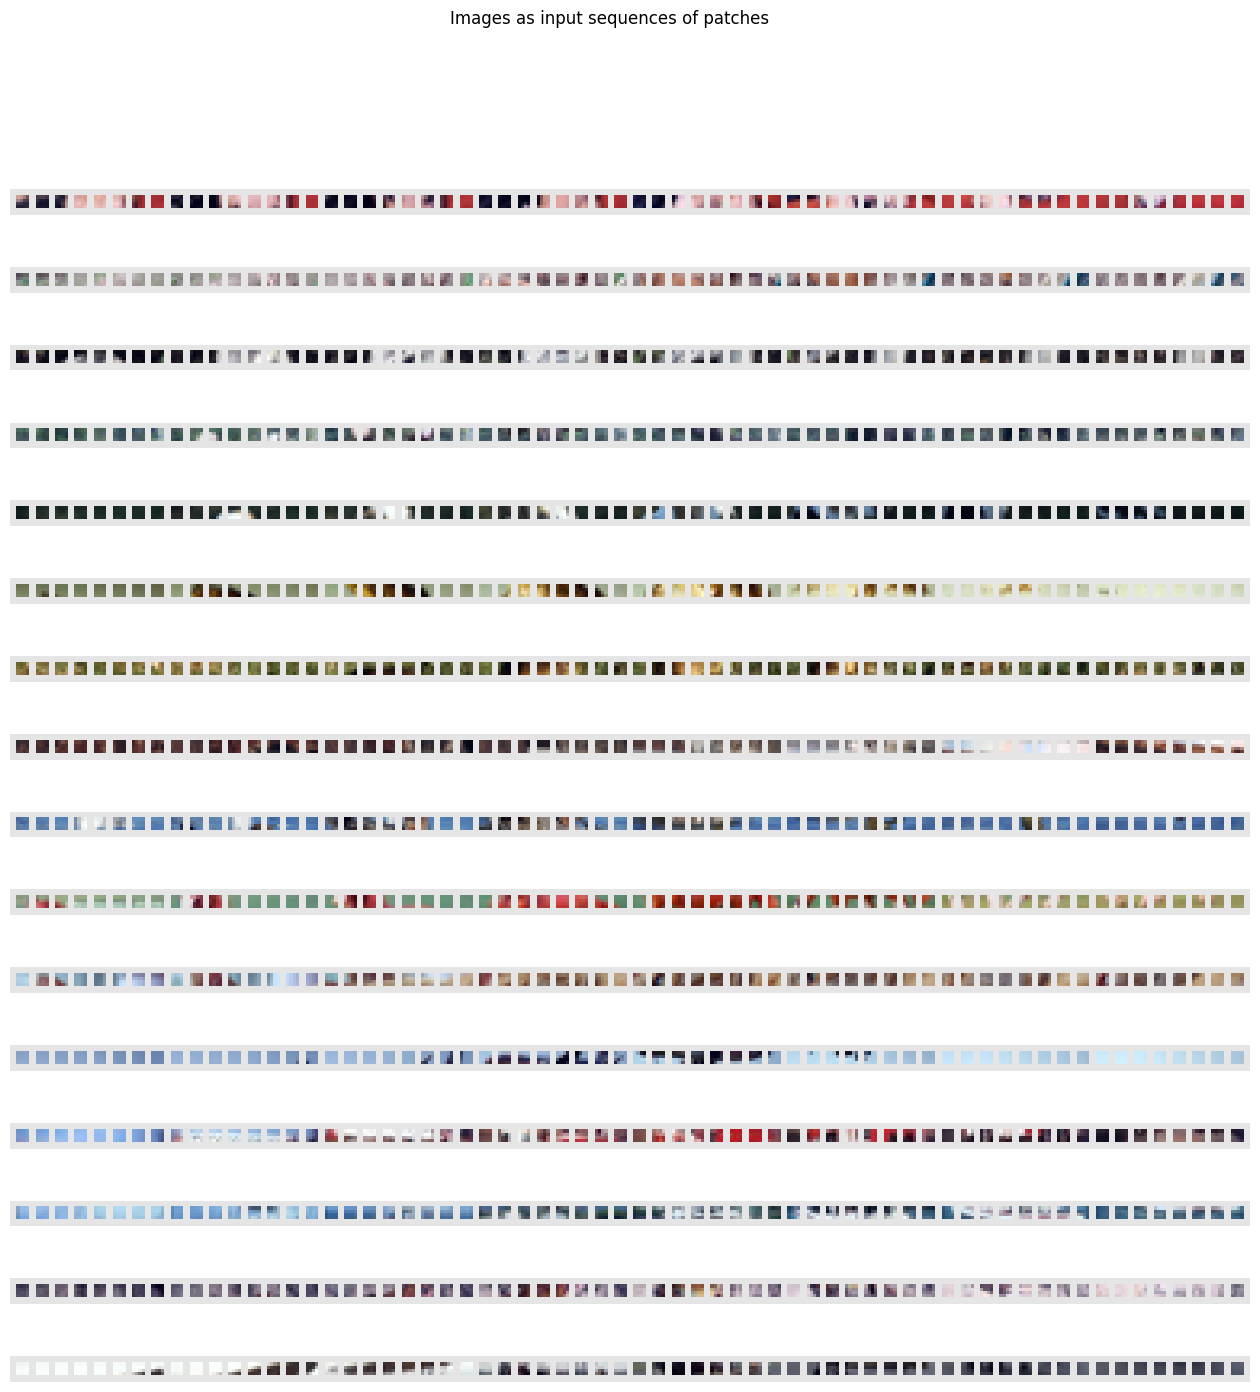

In [7]:
def img_to_patch(x, patch_size = [4, 4]):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches [H, W]
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size[0], patch_size[0], W//patch_size[1], patch_size[1])
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

# --------------------------------------------------task 6 ------------------------------------------------------------
# Task 6.1 Try out different patch sizes and visualize the patches
img_patches = img_to_patch(CIFAR_images, patch_size=[4,4])
B, S, C = img_patches.size()
img_patches_plot = img_patches.reshape(B, S, 3, 4, 4)
print(img_patches.size())

def merge_patch(x):
    """Merge patch into bigger image"""
    B, S, C = x.size()
    x = x.reshape((B, S//4, C*4))
    return x
img_patches = merge_patch(img_patches)
print(img_patches.size())
img_patches = merge_patch(img_patches)
print(img_patches.size())
img_patches = merge_patch(img_patches)
print(img_patches.size())


fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(16,16))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches_plot[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()
CIFAR_images.shape
img_patches = img_to_patch(CIFAR_images, patch_size=[4,4])


torch.Size([16, 4, 768])


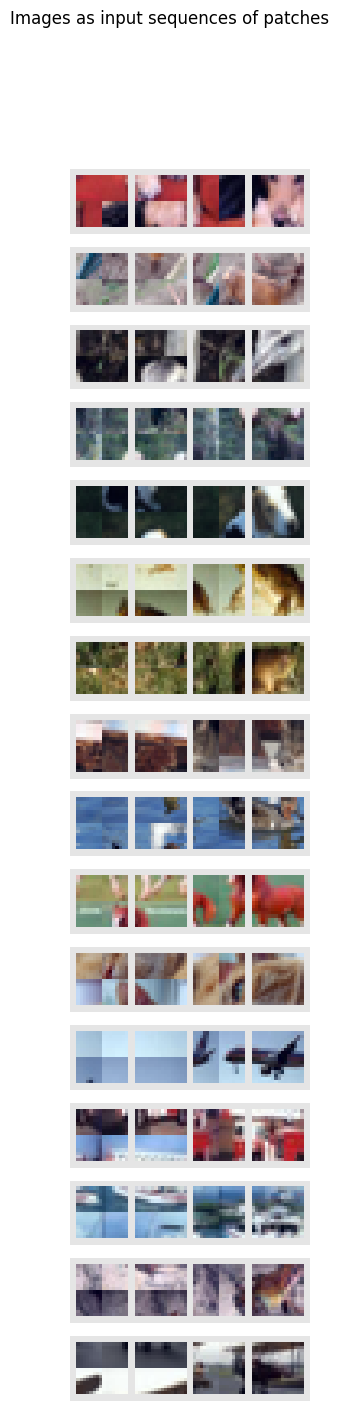

In [16]:
def shift_img_to_patch(x, patch_size = [4, 4]):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches [H, W]
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    H_shift, W_shift = patch_size
    H_shift = H_shift//2
    W_shift = W_shift//2
    
    x_new = torch.zeros_like((x))
    
    x_new[:,:,H_shift:,W_shift:]=x[:,:,:-H_shift,:-W_shift]
    x_new[:,:,:H_shift,:W_shift]=x[:,:,H-H_shift:,W-W_shift:]
    x_new[:,:,H_shift:,:W_shift]=x[:,:,:-H_shift,W-W_shift:]
    x_new[:,:,:H_shift,W_shift:]=x[:,:,H-H_shift:,:-W_shift]
    
    x = img_to_patch(x_new, patch_size)
    return x

# --------------------------------------------------task 6 ------------------------------------------------------------
# Task 6.1 Try out different patch sizes and visualize the patches
img_patches = shift_img_to_patch(CIFAR_images, patch_size=[16,16])
print(img_patches.size())
B, S, _ = img_patches.size()
img_patches_plot = img_patches.reshape(B, S, 3, 16, 16)
fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(16,16))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches_plot[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()



## Function to encode position

torch.Size([1, 96, 48])


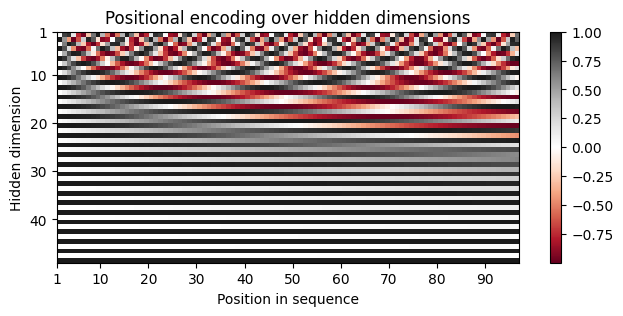

torch.Size([100, 20, 48])

In [17]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1),:]        
        return x
    
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()
print(encod_block.pe.size())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

x = torch.rand((100, 20, 48))
encod_block(x).size()

# Swin Transformer

In [18]:
from collections import OrderedDict

class SwinTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, forward_dim, first_path_size = [4,4], img_origin_size = [32, 32], no_class = 10):
        """
        embed_dim: size of features of embedded dimension of 1 head
        num_heads: number of heads
        """
        assert len(embed_dim) == len(num_heads) == len(forward_dim) <= torch.log2(torch.tensor(img_origin_size)/torch.tensor(first_path_size)).min() + 1, "Check input value dimension again"
        self.depth = len(embed_dim)
        super().__init__()
        
        self.first_path_size = first_path_size
        self.module_list = nn.ModuleList()
        
        # Create a sequence of transformer
        input_dim = input_dim*first_path_size[0]*first_path_size[1]
        sequence_len = img_origin_size[0]*img_origin_size[1]/first_path_size[0]/first_path_size[1]*2
        for i in range(self.depth):
            sequence_len /= 4
            module_dict_i = nn.ModuleDict()
            embed_dim_i = embed_dim[i]
            # Embed layer
            module_dict_i[f"embed_{i}"] = nn.Linear(input_dim, embed_dim_i)
            # Position encoding
            module_dict_i[f"pos_encode_{i}"] = PositionalEncoding(d_model=embed_dim_i, max_len=1024)
            # Transformer block
            module_dict_i[f"transformer_{i}"] = EncoderTransformerBlock(embed_dim_i, num_heads[i], forward_dim[i])
            # Update input_dim for next depth(x)
            input_dim = embed_dim_i*4            
            self.module_list.append(module_dict_i)
        # Last layer
        self.output_project = nn.Linear(embed_dim_i*int(sequence_len*4), no_class)
       
    def forward(self, x):
        i = -1
        x = torch.concat([img_to_patch(x, patch_size=self.first_path_size), shift_img_to_patch(x, patch_size=self.first_path_size)], dim = 1) 
        for i in range(self.depth - 1):
            x = self.module_list[i][f"embed_{i}"](x)
            x = self.module_list[i][f"pos_encode_{i}"](x)
            x = self.module_list[i][f"transformer_{i}"](x)        
            x = merge_patch(x)        
        i+=1
        x = self.module_list[i][f"embed_{i}"](x)
        x = self.module_list[i][f"pos_encode_{i}"](x)
        x = self.module_list[i][f"transformer_{i}"](x)
        x = torch.flatten(x, start_dim = 1)
        x = self.output_project(x)
        return x
   
input_dim = 3
embed_dim = [32, 32, 32, 32]
num_heads = [5, 5, 5, 5]
forward_dim = [64, 64, 64, 64]
first_path_size = [4,4]
img_origin_size = [32, 32]
no_class = 10

test = SwinTransformer(input_dim, embed_dim, num_heads, forward_dim, first_path_size, img_origin_size, no_class)
batch = 100
x = torch.rand((batch, input_dim, *img_origin_size))
print(x.size())
print(test(x).size())

torch.Size([100, 3, 32, 32])
torch.Size([100, 10])


In [19]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import torch.optim.lr_scheduler as lr_scheduler

# Create a class that aid in training and testing
class Model_Wrapper:
    def __init__(self, model, optimizer, scheduler, loss_function, device):
        '''Start the model and store important object'''
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.device = device
        self.total_train_epoch = 0
        self.train_loss_list = []
        self.calculated_metrics = None

    def push_to_device(self):
        self.model = self.model.to(self.device)
        self.loss_function = self.loss_function.to(self.device)

    def train(self, num_epochs, train_loader):
        '''Train model'''
        # Start training
        expected_total_epoch = self.total_train_epoch + num_epochs
        for epoch in range(num_epochs):
            self.model.train()
            for i, (input, output) in enumerate(train_loader, 0):
                # Push data to GPU, clear gradient, calculate loss, backpropagation
                input = input.to(self.device)
                output = output.to(self.device)
                # Zero gradient
                self.optimizer.zero_grad()
                # Forward
                result = self.model(input)
                # Calculate the loss
                loss = self.loss_function(result, output)
                # Calculate the gradient
                loss.backward()
                # Update the weight
                self.optimizer.step()
                # Store the loss value
                self.train_loss_list.append(loss.item())
                # print the loss
                if i % 50 == 0:
                    print(f"Epoch: {self.total_train_epoch+1}/{expected_total_epoch}; Data {i*len(output)}/{len(train_loader.dataset)}; Loss: {loss.item()}")
            self.total_train_epoch += 1
            # Update the learning rate
            scheduler.step()

    def plot_train_loss(self, plot_title = "Loss value during training"):
        """Plot the loss value during training"""
        # Add plot
        _, ax = plt.subplots()
        ax.plot(range(len(self.train_loss_list)), self.train_loss_list)
        # Add a title and labels
        ax.set_title(plot_title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Loss value')

    def test(self, test_loader):
        """Test on test data set"""
        total_loss=[]
        # Test the model
        self.model.eval()
        for i, (input, output) in enumerate(test_loader, 0):
            # Push data to GPU, predict, and calculate the loss
            input = input.to(device)
            output = output.to(device)
            # Predict
            result = self.model(input)
            # Calculate the loss
            loss = self.loss_function(result, output)
            # Append the loss
            total_loss.append(loss.item())
            # Calculate performance
            self.calculate_metrics(result, output)
        # print the loss and metrics
        print(f"Loss: {round(np.array(total_loss).mean(),4)}")
        for metric_name, metric_value in self.calculated_metrics.items():
            print(metric_name, ": ", round(np.array(metric_value).mean(),4), sep="")

    def calculate_metrics(self, result, output):
        """Edit here to calculate the metrics"""
        """Should be individualized"""
        # Make prediction
        _, y_pred = torch.max(result, 1)
        y_pred = y_pred.data.cpu().numpy()
        y_true = output.data.cpu().numpy()
        
        if (self.calculated_metrics == None):
            self.calculated_metrics = {
                "accuracy": [],
                "f1": [],
                "precision": [],
                "recall": []
            }
        self.calculated_metrics["accuracy"].append(accuracy_score(y_true, y_pred))
        self.calculated_metrics["f1"].append(f1_score(y_true, y_pred, average='macro'))
        self.calculated_metrics["precision"].append(precision_score(y_true, y_pred, average='macro', zero_division=1))
        self.calculated_metrics["recall"].append(recall_score(y_true, y_pred, average='macro', zero_division=1))            


In [20]:
input_dim = 3
embed_dim = [32, 32, 32, 32]
num_heads = [5, 5, 5, 5]
forward_dim = [64, 64, 64, 64]
first_path_size = [4,4]
img_origin_size = [32, 32]
no_class = 10

model = SwinTransformer(input_dim, embed_dim, num_heads, forward_dim, first_path_size, img_origin_size, no_class)

beta1 = 0.9
beta2 = 0.999
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(beta1, beta2))
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
net = Model_Wrapper(model, optimizer, scheduler, loss_function, device)
net.push_to_device()

In [69]:
optimizer = optim.Adam(model.parameters(), lr=1e-7, betas=(beta1, beta2))
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
net = Model_Wrapper(model, optimizer, scheduler, loss_function, device)

In [71]:
net.train(1, train_loader)
torch.save(model.state_dict(), 'model_params.pth')

Epoch: 11/11; Data 0/45000; Loss: 0.6279233694076538
Epoch: 11/11; Data 6400/45000; Loss: 0.5730894207954407
Epoch: 11/11; Data 12800/45000; Loss: 0.5762408971786499
Epoch: 11/11; Data 19200/45000; Loss: 0.49476292729377747
Epoch: 11/11; Data 25600/45000; Loss: 0.7262846827507019
Epoch: 11/11; Data 32000/45000; Loss: 0.6175703406333923
Epoch: 11/11; Data 38400/45000; Loss: 0.5618755221366882
Epoch: 11/11; Data 44800/45000; Loss: 0.5963623523712158


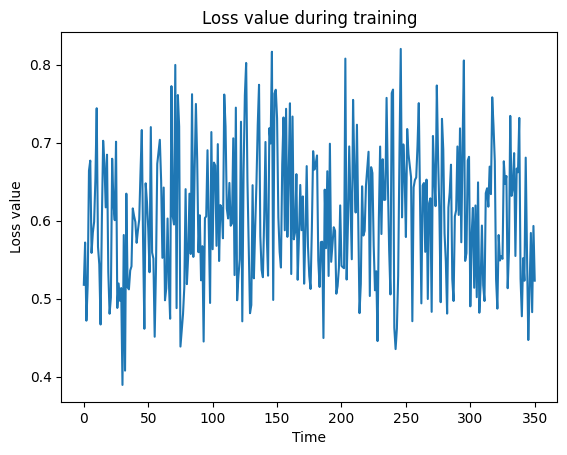

In [65]:
net.plot_train_loss()

In [72]:
net.test(test_loader)

Loss: 0.7846
accuracy: 0.7306
f1: 0.7167
precision: 0.727
recall: 0.7281


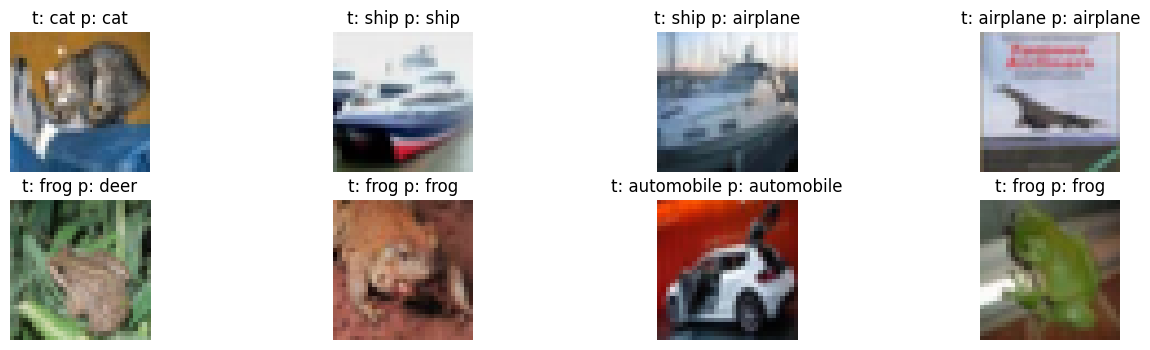

In [73]:
input, output = next(iter(test_loader))
input = input.to(device)
predict = net.model(input)
predict = predict.max(dim=1)[1].detach().cpu()
images = input.cpu()

# Plot
rows = 2
columns = 4
number_of_items = rows*columns
fig = plt.figure(figsize=(16,4))

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.49139968/0.24703223, -0.48215841/0.24348513, -0.44653091/0.26158784],
                         std=[1/0.24703223, 1/0.24348513, 1/0.26158784]),
    transforms.ToPILImage()
])

for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.title(f"t: {labels_list[output[i]]} p: {labels_list[predict[i]]}")
    img = inverse_transform(images[i])
    plt.axis('off')
    plt.imshow(img)
plt.show()